In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder, CIFAR10
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Files already downloaded and verified
Files already downloaded and verified


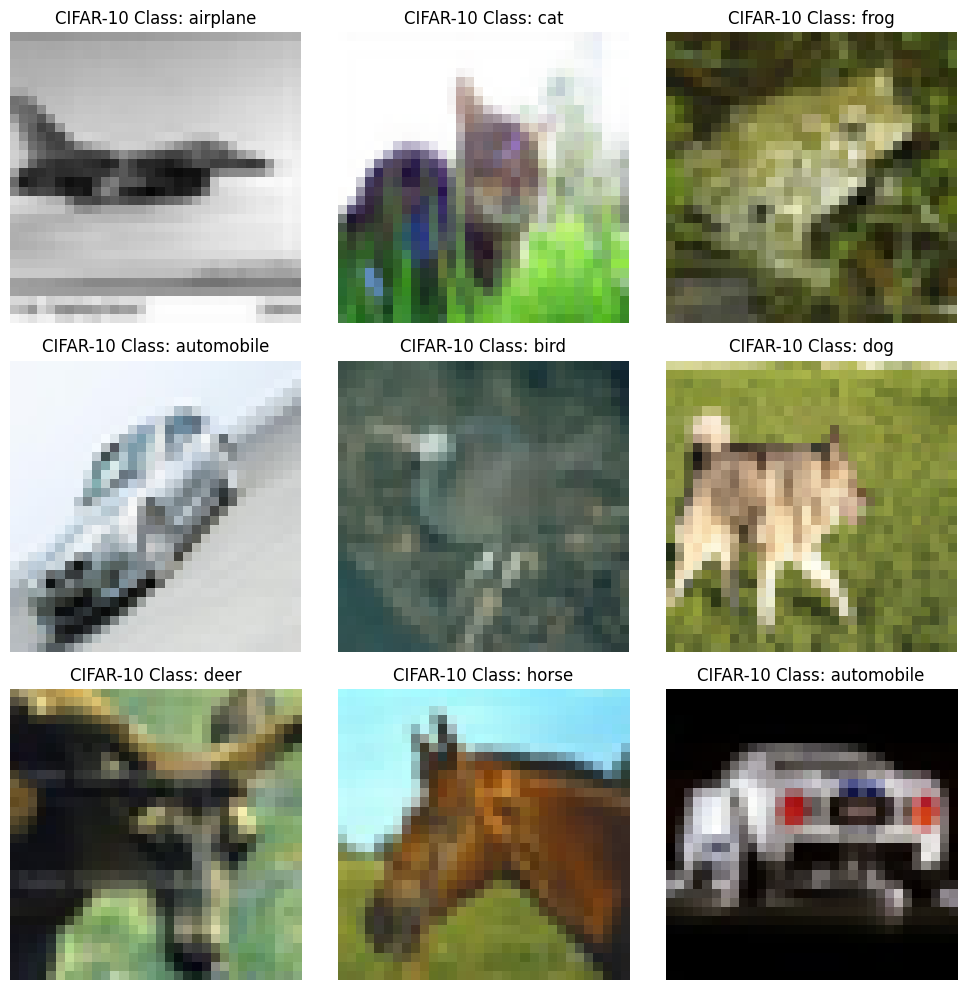

In [2]:
# Define transforms for the images (you can add more augmentation as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset using torchvision
cifar10_train = CIFAR10(root='.', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='.', train=False, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

# Create data loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)  # No need to shuffle test set

# Function to show random images
def show_random_images(dataset, class_names, ncols=3):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), 9)
    
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # (C, H, W) to (H, W, C)
        ax = axes.flat[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'CIFAR-10 Class: {class_names[label]}')
    
    plt.tight_layout()
    plt.show()

# Display random images with labels
show_random_images(train_dataset, cifar10_train.classes)


In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) #we have 3 in channels since we have 3 color rgb. 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 256)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self,x):    
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1) #We flatten our data along the color channels. So, first we had [batch_size, channels, height, width] and now we will have [batch_size, channels * height * width].
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        return x
        


In [4]:
num_classes = len(cifar10_train.classes) # Number of classes is based on the dataset
model = CNN(num_classes)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001) #We will use the Adam optimizer in this case. 
print(model)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
def train_model(model, optimizer, loss_fn, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        
        # Training phase
        model.train()  # Set the model to training mode
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # Print every 100 mini-batches
                print(f'Training: Epoch [{epoch + 1}, {i + 1}], Loss: {running_loss / 10:.3f}')
                running_loss = 0.0
        
        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, loss_fn, test_loader)
        print(f'End of Epoch {epoch + 1}. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    print('Finished Training')

# Assuming evaluate_model function is defined as per previous discussions
def evaluate_model(model, loss_fn, data_loader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy


In [7]:
train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10)

Training: Epoch [1, 10], Loss: 2.223
Training: Epoch [1, 20], Loss: 2.199
Training: Epoch [1, 30], Loss: 2.199
Training: Epoch [1, 40], Loss: 2.187
Training: Epoch [1, 50], Loss: 2.188
Training: Epoch [1, 60], Loss: 2.201
Training: Epoch [1, 70], Loss: 2.166
Training: Epoch [1, 80], Loss: 2.154
Training: Epoch [1, 90], Loss: 2.194
Training: Epoch [1, 100], Loss: 2.187
Training: Epoch [1, 110], Loss: 2.191
Training: Epoch [1, 120], Loss: 2.200
Training: Epoch [1, 130], Loss: 2.205
Training: Epoch [1, 140], Loss: 2.187
Training: Epoch [1, 150], Loss: 2.162
Training: Epoch [1, 160], Loss: 2.184
Training: Epoch [1, 170], Loss: 2.201
Training: Epoch [1, 180], Loss: 2.219
Training: Epoch [1, 190], Loss: 2.183
Training: Epoch [1, 200], Loss: 2.156
Training: Epoch [1, 210], Loss: 2.146
Training: Epoch [1, 220], Loss: 2.174
Training: Epoch [1, 230], Loss: 2.171
Training: Epoch [1, 240], Loss: 2.188
Training: Epoch [1, 250], Loss: 2.154
Training: Epoch [1, 260], Loss: 2.172
Training: Epoch [1, 2

In [8]:
# Final evaluation on test set
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 1.9454, Test Accuracy: 0.3222
